# Взлом шифра Виженера

Основная идея шифра Вижнера - выбор слова определенной длины, повторение его до тех пор, пока он не станет размером с новый текст, образуя ключ. Затем каждую букву исходного текста сдвигают на номер соответствующей буквы ключа в алфавите. 

Исходный текст написан на русском языке. Не сложно предположить, что алфавит для шифра Вижнера - русский.

Рассмотрим частотный анализ русских символов в осмысленном тексте.

In [17]:
import string      # definitions of ascii printable chars
from collections import defaultdict     # fast counting
import typing as tp

def generate_frequencies(text: str) -> tp.Dict:
    d = defaultdict(int)    # define dictionary for counting frequencies

    for ch in text:       # loop over each character 
        if (ch >= 'а' and ch <= 'я'):
            d[chr(ord(ch) - 32)] += 1    #   if so, add 1 to that characters frequency counter
        elif (ch >= 'А' and ch <= 'Я'):
            d[ch] += 1
    return d

ref_files = [
    "./data/ref_texts/war_and_peace.ru.txt",
    #"./data/addition/war_and_peace.txt"
]

total_txt = ""
for path in ref_files:
    file = open(path, "r", encoding="utf-8")
    data = file.read()
    print(f"{path}, content: {data[0:100]}")
    total_txt += data
    file.close()
    
tmp_d = generate_frequencies(total_txt)
alphabet = list(tmp_d.keys())
alphabet.sort()
alphabet.insert(6, 'Ё')
print(alphabet)

./data/ref_texts/war_and_peace.ru.txt, content: Лев Николаевич Толстой
Война и мир. Книга 1

Война и мир – 1

Аннотация 

Роман Льва Толстого «Война
['А', 'Б', 'В', 'Г', 'Д', 'Е', 'Ё', 'Ж', 'З', 'И', 'Й', 'К', 'Л', 'М', 'Н', 'О', 'П', 'Р', 'С', 'Т', 'У', 'Ф', 'Х', 'Ц', 'Ч', 'Ш', 'Щ', 'Ъ', 'Ы', 'Ь', 'Э', 'Ю', 'Я']


In [18]:
tmp_d.update({'Ё':tmp_d['Ъ'] / 2})
print(tmp_d.keys(), len(tmp_d.keys()))     # print all frequencies

letters_possibilities = {k: v for k, v in sorted(tmp_d.items(), key=lambda item: item[1], reverse=True)}
print(letters_possibilities.keys(), len(letters_possibilities.keys()))

dict_keys(['Л', 'Е', 'В', 'Н', 'И', 'К', 'О', 'А', 'Ч', 'Т', 'С', 'Й', 'М', 'Р', 'Г', 'Ц', 'Я', 'Ь', 'Ж', 'З', 'Д', 'У', 'Ы', 'П', 'Ю', 'Х', 'Б', 'Э', 'Щ', 'Ш', 'Ф', 'Ъ', 'Ё']) 33
dict_keys(['О', 'А', 'Е', 'И', 'Н', 'Т', 'С', 'Л', 'В', 'Р', 'К', 'Д', 'М', 'У', 'П', 'Я', 'Г', 'Ь', 'Ы', 'Б', 'З', 'Ч', 'Й', 'Ж', 'Ш', 'Х', 'Ю', 'Ц', 'Э', 'Щ', 'Ф', 'Ъ', 'Ё']) 33


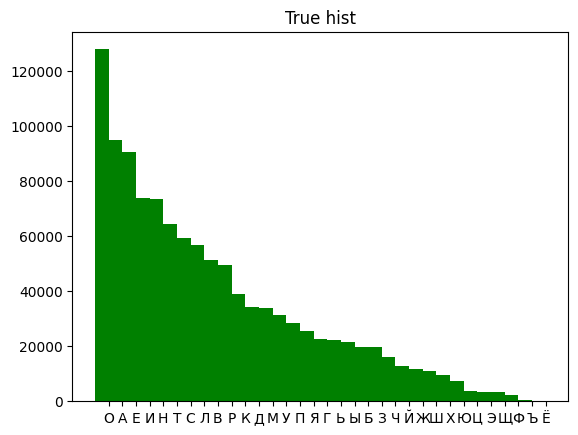

In [19]:
import numpy as np
import matplotlib.pyplot as plt

def plot_hist(dct, title):
    pos = np.arange(len(dct.keys()))
    width = 1.0     # gives histogram aspect to the bar diagram

    ax = plt.axes()
    ax.set_xticks(pos + (width / 2))
    ax.set_xticklabels(dct.keys())

    plt.bar(dct.keys(), dct.values(), width, color='g')
    plt.title(title)
    plt.show()
    return

plot_hist(letters_possibilities, "True hist")


### Определение длины ключа

Будем брать буквы на определенных отступах и смотреть на гистограммы распределений. Если гистограммы будут схожи, но только со сдвигом, то значит, что эти буквы получены одинаковым сдвигом. Это может означать или длину ключа, или совпадение сиволов на двух разных позициях кодового слова. Данную гистограмма с разными сдвигами должна наблюдаться и при последующих наборов символов: если бы исходный текст был закодирован к примеру словом САПСАН, то можно предположить, что длина кода 3, а не 6, поскольку гистограмма была бы схожа с тем, что сверху. Без проверок всех последующих символов, нельзя было бы заметить несостыковку распределение каждого 3ьего символа с тем, что приведено выше.

In [20]:
text_path = "./data/2024_11_08_17_45_19_Сачук_Александр_task.txt"
data = ""
with open(text_path, "rt", encoding="utf-8") as tf:
    data = tf.read()
    
print(len(data), data[0:200])

20000 Г ЕРТЫ Х ЖКГЙЬРВТ, ГЕФ ВЭДМВПЧПЁШДШЪ ПФАУУАИ ДЬЬУШЧЮПЩЙ Ь ЯВПУБЯЕ, К УНЭЮАЦЩП, ТШЩЦМУЗ-ЭР НОЦ Ш ЯЕУФЁЭР НВ ЮЬЖК АНЮТК УААФЦЁ, ИБ-АЖ-ЦУ! НШФФ, ХШЪЯ, ТЬЁЪГМБ ЯЪУЦПБ АВШСЙВЮУЩ, ТЫРФАЁЕЛ ХЖ ЯЬЧК ЧППМ, ГВЬ


In [21]:
def remain_symbs(source_text : str) -> str:
    res = "".join([symb for symb in source_text if (symb >= 'А' and symb <= 'Я') or symb == 'Ё'])
    return res

def count_ci(source_text : str, is_need_to_drop_non_symbs: bool, key_len: int):
    text = source_text
    if is_need_to_drop_non_symbs:
        text = remain_symbs(text)

    # init dicts of frequencies for every shift
    keys = [chr(ch) for ch in range(ord('А'), ord('Я') + 1)]
    keys.insert(6, 'Ё')
    #print(keys)
    dict_letters = {key: 0 for key in keys}
        
    # count frequencies on every shift
    total_cnt = 0
    for i, ch in enumerate(text):
        if ((ch >= 'А' and ch <= 'Я') or ch == 'Ё') and i % key_len == 0:   
            dict_letters[ch] += 1
            total_cnt += 1
    
    # plot every freq hist
    ci = 0
    for key in keys:  
        ci += dict_letters[key] * (dict_letters[key] - 1) / (total_cnt * (total_cnt - 1))
         
    return ci

In [22]:
max_val, max_i = 0, -1
list_ci = []
for i in range(1, 100):
    val = count_ci(data, True, i)
    list_ci.append(val)
    if (val > max_val):
        max_val = val
        max_i = i
    #print(f"ci of '{i}' is d={val}")
    
print(f"Best ci is of '{max_i}' is d={max_val}")

Best ci is of '80' is d=0.06409914000320494


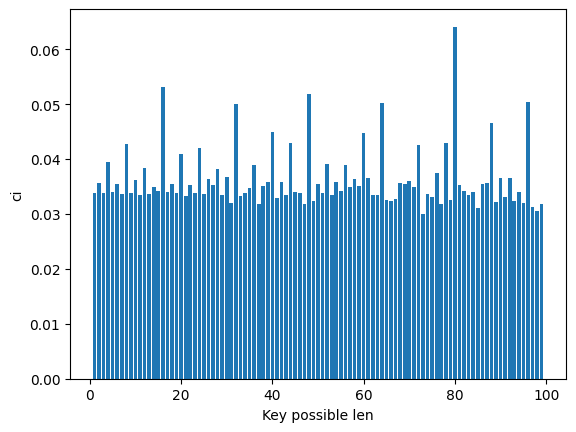

In [23]:
plt.bar(range(1, len(list_ci) + 1), list_ci)
plt.xlabel("Key possible len")
plt.ylabel("ci")
plt.show()

Видны пики значений ci в различных позициях. Будем предполагать, что ключ короткий =), и всего из 16 букв. Приступим к перебору!

Загружаем частотный словарь русских слов

In [24]:
import pandas as pd

df = pd.read_csv("./data/freqrnc2011.csv", delimiter='\t')
df = df[['Lemma', 'Doc']]
df = df.sort_values('Doc', ascending=False)
print(df.head())
sorted_freq_lemmas = df['Lemma'].to_list()
sorted_freq_lemmas = [str.upper(lemma) for lemma in sorted_freq_lemmas]
#print(sorted_freq_lemmas)
print(len(sorted_freq_lemmas))


      Lemma    Doc
3710      в  37865
13824     и  37704
22019    на  36748
40004     с  35700
3683   быть  34184
52138


Читаем дополнительно разные литературные источники, чтоб добавить разные словообразования. Добавим их в конец всего нашего словаря, поскольку эти словообразования явно маловерятнее своих базовых форм, но и вероятность точную ко всему языку без дополнительных исследований оценить точно. Пускай будут в конце 

In [25]:
import string
import re

def eject_words(text:str) -> tp.List[str]:
    words = [str.upper(word.strip(string.punctuation)) for word in text.split()]
    new_list = []
    for i in range(len(words)):
        word = re.sub(r'[^а-яА-ЯёЁ]', '', words[i])
        if (len(word)) > 0:
            new_list.append(word)
    return list(set(new_list))

texts = [
    "./data/ref_texts/war_and_peace.ru.txt",
    "./data/ref_texts/Булгаков. Мастер и Маргарита (1).txt"
    ]

new_words = []
for text_path in texts:
    with open(text_path, "rt", encoding="utf-8") as tfile:
        text = tfile.read()
        tmp_new_words = eject_words(text)
        new_words += tmp_new_words
        
new_words = list(set(new_words))
print(new_words[0:30])

['УМОЛОТОМ', 'ВРАГАМИ', 'ЗАМШЕВОМ', 'ГРОЗИЛА', 'БЕСЕДЫ', 'ПРИЗВАЛ', 'МРАЧНЫЕ', 'СТРАШНЫМ', 'СБЕЖАЛИ', 'РОДЯТСЯ', 'СКРЫТО', 'УЛЮЛЮ', 'ДЕВ', 'ОТДАДУТ', 'УМИРАЯ', 'РОЗ', 'ПЕРЕБИЛА', 'СПУСКАЛИСЬ', 'ХРИПЕЛА', 'БИЛЕТИКОВ', 'ПОЦЕЛУЙТЕ', 'БЕРЛИНСКОЕ', 'МЕТНУЛАСЬ', 'БЕСПРИЧИННОЕ', 'ДОСЛУШАЛА', 'МОЛЧИТЕ', 'ПОСЫЛАЕТ', 'НЕРАЗРЕЗАННУЮ', 'НЕДОУМЕНИЕМ', 'СУПРУГОМ']


In [26]:
sorted_freq_lemmas += new_words

In [27]:
lemmas_by_lenght = {i: [] for i in range(1, 25)}
for lemma in sorted_freq_lemmas:
    if "-" in lemma:
        continue
    lemmas_by_lenght[len(lemma)].append(lemma)
    
for key in lemmas_by_lenght.keys():
    lemmas_by_lenght[key].reverse()
    
#print(lemmas_by_lenght)

In [28]:
import typing as tp
from typing_extensions import TypedDict
from pydantic import Field
import string
from collections import deque


class AnswerStatus(TypedDict):
    answer_text: str = Field('', description="Hypothesis true answer text. Will be filled while count of letters not be over key lenght")
    words_count: int = Field(0, description="Words count")
    answer_letters_count: int = Field(0, description="Count of letters in answer text")
    

class PossibleAnswer(TypedDict):
    original_text: str = Field('', description="Founded text")
    shifts: tp.List[int] = Field([], description="Shifts generated by key")
    

class RussianLanguageHelper():
    rus_letters_count = 33
    rus_alphabet = alphabet
    rus_letters_map = {ch: i for i, ch in enumerate(alphabet)} # i + 1 because 'А' in key makes one shift left, not zero 
    
    @staticmethod
    def rus_ord(letter: str) -> int:
        return RussianLanguageHelper.rus_letters_map[letter]
    
    @staticmethod
    def rus_chr(letter_id : int) -> str:
        return RussianLanguageHelper.rus_alphabet[letter_id]
    
    @staticmethod
    def convert_e_diaeresis_to_e(word: str) -> str:
        return word.replace('Ё', 'Е')
    
def generate_answer(ciphertext: str, shifts: tp.List[int]) -> str:
    answer = ''
    
    current_pos = 0
    for ch in ciphertext:
        if ch in RussianLanguageHelper.rus_alphabet:
            orig_ord = (RussianLanguageHelper.rus_ord(ch) - shifts[current_pos % len(shifts)]) % RussianLanguageHelper.rus_letters_count
            orig_letter = RussianLanguageHelper.rus_chr(orig_ord)
            answer += orig_letter
            current_pos += 1
        else:
            answer += ch
    
    return answer


def is_text_valid(pos_text:str, words_probs:tp.Dict, max_words_to_check:int, eps:float=0.) -> bool:
    words = [word.strip(string.punctuation) for word in pos_text.split()]
    
    error_words_cnt, total_words = 0, 0
    for i, word in enumerate(words):
        if i > max_words_to_check:
            break
        
        total_words += 1
        prep_word = RussianLanguageHelper.convert_e_diaeresis_to_e(word)
        if prep_word not in words_probs[len(prep_word)]:
            error_words_cnt += 1
            if eps == 0:
                return False, 0
            
    if error_words_cnt / total_words > eps:
        return False, error_words_cnt / total_words
    else:
        return True, error_words_cnt / total_words

def find_text_by_words(ciphertext: str, key_len: int, words_probs: tp.Dict, max_words_to_check:int) -> str:
    answers_stack = deque()
    possible_founded_answers = deque()
    
    optimal_shift = []
    min_eps = 1.
    
    # prepare words lenght
    words = [word.strip(string.punctuation) for word in ciphertext.split()]
    
    # concatenated words of ciphertext for shifts counting
    concat_ciphertext = remain_symbs(ciphertext)[0:key_len]
    if len(concat_ciphertext) < key_len:
        return
    concat_ciphertext = concat_ciphertext[:key_len]
    
    # prepare statuses based on first word in cipher text
    for word in words_probs[len(words[0])]:
        answer_status = AnswerStatus()
        
        answer_status['answer_text'] = word
        answer_status['words_count'] = 1
        answer_status['answer_letters_count'] = len(word)
        
        answers_stack.append(answer_status)
       
    # make recursive search 
    while len(answers_stack) > 0:
        old_status = answers_stack.pop()
        
        # If we dont have yet info about 
        if old_status['answer_letters_count'] < key_len:
            for word in words_probs[len(words[old_status['words_count']])]:
                new_status = AnswerStatus()
        
                new_status['answer_text'] = old_status['answer_text'] + word
                new_status['words_count'] = old_status['words_count'] + 1
                new_status['answer_letters_count'] = old_status['answer_letters_count'] + len(word)
        
                answers_stack.append(new_status)
        else:
            # count possible shifts for phrase
            possible_true_text = old_status['answer_text']
            shifts = []
            for i, ch in enumerate(concat_ciphertext):
                ch_ord = RussianLanguageHelper.rus_ord(ch)
                orig_ord = RussianLanguageHelper.rus_ord(possible_true_text[i])
                shifts.append((ch_ord - orig_ord) % 33)
                
            # generate for them possible answer
            pos_answer = generate_answer(ciphertext, shifts)
            
            # check answer for valid
            is_valid, error_rate = is_text_valid(pos_answer, words_probs, max_words_to_check, eps=0.05)
            if min_eps > error_rate:
                optimal_shift = shifts
                min_eps = error_rate
                print(f"---NEW MIN EPS: {min_eps}. POS ANSWER IS: {pos_answer[0:100]}")
            
            if is_valid:
                print(f"POSSIBLE ANSWER: {pos_answer[0:100]}")
            
                new_pos_answer = PossibleAnswer()
                new_pos_answer['original_text'] = pos_answer
                new_pos_answer['shifts'] = shifts                
                possible_founded_answers.append(new_pos_answer)
            #else:
                #print(f"FAILED: {pos_answer[0:100]}")
    
    print(f"Optimal eps: {optimal_shift}, shift: {min_eps}")
    return possible_founded_answers

In [29]:
answers = find_text_by_words(data, 16, lemmas_by_lenght, max_words_to_check=30)

---NEW MIN EPS: 0.7096774193548387. POS ANSWER IS: В БЫТЬ В ГОВОРИТЬ, ЧТУ ЮЗДНОЛЫОКМЬИД ДВЯПЮАЙ РШАТЭЛЦАГЮ Й ЮЮЪУВЛБ, О ТТСЦРАНЭ, СФДЦНАД-БП ТГО И ИЩБУ


KeyboardInterrupt: 

Способ перебора текста длился достаточно долго. Возможно проблема в том, что нет нужных слов. Возможно в том, что нужны слова с буквой Ё. Ниже представлен второй способ - перебор сдвигов на каждую позицию по частотам.

In [30]:
class FreqAnswerStatus(TypedDict):
    current_shifts: tp.List[int] = Field(default=[], description="Possible shifts")
    key_rot1: str = Field(default='', description="Key created by shifts (if A makes one shift)")
    key_rot0: str = Field(default='', description="Key created by shifts (if A makes zero shift)")

def count_freqs(ciphertext: str, key_len: int):
    freqs_per_step_dicts = []
    
    text = remain_symbs(ciphertext)
    
    # create dicts
    print(RussianLanguageHelper.rus_alphabet)
    for _ in range(key_len):
        new_dict = {ch: 0 for ch in RussianLanguageHelper.rus_alphabet}
        freqs_per_step_dicts.append(new_dict)
    
    # count freqs
    for i, ch in enumerate(text):
        freqs_per_step_dicts[i % key_len][ch] += 1
        
    # sort in increase freqs
    freqs_per_step = []
    for i in range(key_len):
        freqs_per_step.append({k: v for k, v in sorted(freqs_per_step_dicts[i].items(), key=lambda item: item[1])}.keys())
    
    return freqs_per_step

def find_text_by_frequencies(ciphertext: int, key_len: int, words_probs: tp.Dict, max_words_to_check:int) -> str:
    answers_stack = deque()                 # stack for searcing results
    possible_founded_answers = deque()      # stack for possible answers
    
    # vars about possible shifts
    optimal_shift = []
    min_eps = 1.
    
    # frequencies of letters
    freqs_per_key_pos = count_freqs(ciphertext, key_len)
    
    # prepare statuses based on first word in cipher text
    for freq in freqs_per_key_pos[0]:
        answer_status = FreqAnswerStatus()
        
        true_max_freq_ord = RussianLanguageHelper.rus_ord('О')
        pos_max_freq_ord = RussianLanguageHelper.rus_ord(freq)
        shift = (pos_max_freq_ord - true_max_freq_ord) % RussianLanguageHelper.rus_letters_count
        
        answer_status['current_shifts'] = [shift]
        answer_status['key_rot1'] = RussianLanguageHelper.rus_chr((shift - 1) % RussianLanguageHelper.rus_letters_count)
        answer_status['key_rot0'] = RussianLanguageHelper.rus_chr(shift)
        
        answers_stack.append(answer_status)
       
    # make recursive search 
    while len(answers_stack) > 0:
        old_status = answers_stack.pop()
        
        # If we dont have yet info about 
        if len(old_status['current_shifts']) < key_len:
            for freq in freqs_per_key_pos[len(old_status['current_shifts'])]:
                answer_status = FreqAnswerStatus()
        
                true_max_freq_ord = RussianLanguageHelper.rus_ord('О')
                pos_max_freq_ord = RussianLanguageHelper.rus_ord(freq)
                shift = (pos_max_freq_ord - true_max_freq_ord) % RussianLanguageHelper.rus_letters_count
        
                answer_status['current_shifts'] = old_status['current_shifts'] + [shift]
                answer_status['key_rot1'] = old_status['key_rot1'] + RussianLanguageHelper.rus_chr((shift - 1) % RussianLanguageHelper.rus_letters_count)
                answer_status['key_rot0'] = old_status['key_rot0'] + RussianLanguageHelper.rus_chr(shift)
        
                answers_stack.append(answer_status)
        else:
            # generate for them possible answer
            pos_answer = generate_answer(ciphertext, old_status['current_shifts'])
            
            # check answer for valid
            is_valid, error_rate = is_text_valid(pos_answer, words_probs, max_words_to_check, eps=0.05)
            if min_eps > error_rate:
                optimal_shift = old_status['current_shifts']
                min_eps = error_rate
                print(f"---NEW MIN EPS: {min_eps}. POS ANSWER IS: {pos_answer[0:2000]}. POS KEY0: {old_status['key_rot0']}, POS KEY1: {old_status['key_rot1']}.---")
            
            if is_valid:
                new_pos_answer = PossibleAnswer()
                new_pos_answer['original_text'] = pos_answer
                new_pos_answer['shifts'] = old_status['current_shifts']                
                possible_founded_answers.append(new_pos_answer)
    
    print(f"Optimal eps: {optimal_shift}, shift: {min_eps}")
    return possible_founded_answers

In [31]:
answers = find_text_by_frequencies(data, 16, lemmas_by_lenght, max_words_to_check=30)

['А', 'Б', 'В', 'Г', 'Д', 'Е', 'Ё', 'Ж', 'З', 'И', 'Й', 'К', 'Л', 'М', 'Н', 'О', 'П', 'Р', 'С', 'Т', 'У', 'Ф', 'Х', 'Ц', 'Ч', 'Ш', 'Щ', 'Ъ', 'Ы', 'Ь', 'Э', 'Ю', 'Я']
---NEW MIN EPS: 0.1935483870967742. POS ANSWER IS: У СЕБЯ В КАБИНЕТЕ, ВСЕ ОСТРОУМНЕЙШИМ ОБРАЗОМ РАССЧИТАЛИ И ПОДВЕЛИ, А СМОТРИШЬ, ГЕНЕРАЛ-ТО МАК И СДАЕТСЯ СО ВСЕЙ СВОЕЙ АРМИЕЙ, ХЕ-ХЕ-ХЕ! ВИЖУ, ВИЖУ, БАТЮШКА РОДИОН РОМАНОВИЧ, СМЕЕТЕСЬ ВЫ НАДО МНОЮ, ЧТО Я, ТАКОЙ СТАТСКИЙ ЧЕЛОВЕК, ВСЕ ИЗ ВОЕННОЙ ИСТОРИИ ПРИМЕРЧИКИ ПОДБИРАЮ. ДА ЧТО ДЕЛАТЬ, СЛАБОСТЬ, ЛЮБЛЮ ВОЕННОЕ ДЕЛО, И УЖ ТАК ЛЮБЛЮ Я ЧИТАТЬ ВСЕ ЭТИ ВОЕННЫЕ РЕЛЯЦИИ… РЕШИТЕЛЬНО Я МОЕЙ КАРЬЕРОЙ МАНКИРОВАЛ. МНЕ БЫ В ВОЕННОЙ СЛУЖИТЬ-С, ПРАВО-С. НАПОЛЕОНОМ-ТО, МОЖЕТ БЫТЬ, И НЕ СДЕЛАЛСЯ БЫ, НУ А МАЙОРОМ БЫ БЫЛ-С, ХЕ-ХЕ-ХЕ! НУ-С, ТАК Я ВАМ ТЕПЕРЬ, РОДИМЫЙ МОЙ, ВСЮ ПОДРОБНУЮ ПРАВДУ СКАЖУ НАСЧЕТ ТОГО ТО ЕСТЬ ЧАСТНОГО СЛУЧАЯ-ТО: ДЕЙСТВИТЕЛЬНОСТЬ И НАТУРА, СУДАРЬ ВЫ МОЙ, ЕСТЬ ВАЖНАЯ ВЕЩЬ И УХ КАК ИНОГДА САМЫЙ ПРОЗОРЛИВЕЙШИЙ РАСЧЕТ ПОДСЕКАЮТ! ЭЙ, ПОСЛУШАЙТЕ СТАРИКА, СЕРЬЕЗНО ГОВОРЮ, РОДИ

KeyboardInterrupt: 

Достатчно быстро определился вторым способом ключ: ОТКРЫТЫЙБАНКОМАТ

Исходный текст: Ф. М. Достоевский. Преступление и наказание

По гистограмме индекса схожести видно, что похожий индейс имеют все числа кратные 16 (а 80 - вообще самый большой). На этих числах алгоритм тоже будет работать, только сильно дольше. Как стоит полагать, при предположении о длине ключа в 32, ключ должен оказаться дважды повторенным кодом 'ОТКРЫТЫЙБАНКОМАТ'

In [16]:
answers = find_text_by_frequencies(data, 32, lemmas_by_lenght, max_words_to_check=30)

['А', 'Б', 'В', 'Г', 'Д', 'Е', 'Ё', 'Ж', 'З', 'И', 'Й', 'К', 'Л', 'М', 'Н', 'О', 'П', 'Р', 'С', 'Т', 'У', 'Ф', 'Х', 'Ц', 'Ч', 'Ш', 'Щ', 'Ъ', 'Ы', 'Ь', 'Э', 'Ю', 'Я']
---NEW MIN EPS: 0.6774193548387096. POS ANSWER IS: У СОБЯ В КАБТНЕЬЕ, ВСО ОСТРШУМНЕЙШИМ ОКРАСОМ РАССБИТЙЛИ И ЩОДВЕХИ, А СМОТРИШЁ, ГЕЧЕРАЛ-ТО ЦАК Т СДАОТСЯ СШ ВСЕЙ СВОЕЙ ЙРМТЕЙ, ХЕ-ХЕ-ЯЕ! ВТЖУ, ВТЖУ, БАЬЮШКА РОДИОЧ РОЦАНОВИЧ, ЫМЕОТЕСЁ ВЫ НАНО МНОЮ, ЧТО Я, ЬАКШЙ СТАТСФИЙ БЕЛОЛЕК, ВСО ИЗ ВОЕННОЙ ТСТШРИИ ПРИЦЕРБИКИ ЩОДБИЪАЮ. ДА ЧТО ДЕХАТЁ, СЛАБОСЬЬ, ЛЗБЛЮ ЛОЕННШЕ ДЕЛО, И УЖ ТЙК ЛЗБЛЮ Я ЧИЬАТЁ ВСЕ ЖТИ ВООННЫЕ РЕЛЯЦТИ… РОШИТЕЛЬЧО Я ЦОЕЙ ФАРЬЕЪОЙ МАНКИРОЛАЛ. ЦНЕ БЫ В ВШЕНЧОЙ СХУЖИТЁ-С, ПРАВО-С. НАЩОЛООНОМ-ТО, ЦОЖОТ БЫЬЬ, И НЕ ЫДЕЛАЛСЯ БЫ, ЧУ А ЦАЙОРОМ КЫ БЕЛ-С, ХО-ХЕ-ХЕ! ЧУ-С, ТАК Я ВАМ ЬЕПОРЬ, РОДИЦЫЙ ЦОЙ, ВЫЮ ПОДЪОБНУЮ ПРАВНУ СФАЖУ НАСБЕТ ЬОГО ЬО ЕСТЁ ЧАСТНОГО СХУЧЙЯ-ТО: ДЕЙЫТВТТЕЛЁНОСТЁ И НАТУРА, СУНАРЁ ВЫ МОЙ, ЕЫТЬ ЛАЖНЙЯ ВЕЩЁ И УХ КАК ИНОМДА ЫАМЫЙ ПРШЗОЪЛИВОЙШИЙ ЪАСЧЕТ ПОДСОКАЗТ! ЭЙ, ПОСХУШЙЙТЕ ЫТАРИФА, СЕРЬЕЗНО МОВШРЮ, РОДИ

KeyboardInterrupt: 

## Выводы

Два предложенных алгоритма (на основе перебора встречающихся слов и на основе сдвига максимальных распределений на позициях) хоть в теории и помогают найти алгоритм, полагаясь на вероятностную природу языка, однако все равно являются достаточно медленными: первый алгоритм вообще так то и не смог найти нужный ключ, поскольку пришлось бы перебирать слишком большое кол-во первых слов, покрывающие размер ключа (порядка 20 * 20 * 800 * 2600 * 10000, если верить собранному словарю), а это даже не гарантированно, что все нужные слова в данном словаре есть. Кроме того, эмпирически кажется, что преимущественное большинство слов, кроме разве что предлогов и ряда распространненых в бытовой жизни слов, не имеют каких либо частотных выбоин. Как показывает

Второй алгоритм требует не меньшего перебора: 33^16, но и распределение гласных более неравномерное (гласная 'о' встречается сильно чаще остальных букв, а мы перебираем сдвиги полагая, что максимум распределения символов после сдвига соответствует букве 'о' до сдвига). В целом, такая стратегия дает почти готовый результа (как видно по предыдущей ячейке), однако чем больше длина ключа, тем дольше и перебор. Можно в целом модернизировать стратегию атаки, пытаясь после нахождения почти готового ключа заменять некоторые буквы слов, которые почти правильно написаны. 